<a href="https://colab.research.google.com/github/jgermanob/DeepLearning/blob/master/T01/AP_T01_Ej04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Red completamente conectada con PyTorch

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:
* Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
* Discute tus resultados con las distintas configuraciones.

### Bibliotecas

In [ ]:
!pip install torchinfo

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### Funciones auxiliares

In [ ]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

### Exploración de datos

PyTorch provee la clase [`MNIST`](https://pytorch.org/vision/0.8/datasets.html#mnist), una implementación de `Dataset` lista para usar del conjunto MNIST.

In [ ]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


images[0] shape=(28, 28) dtype=uint8


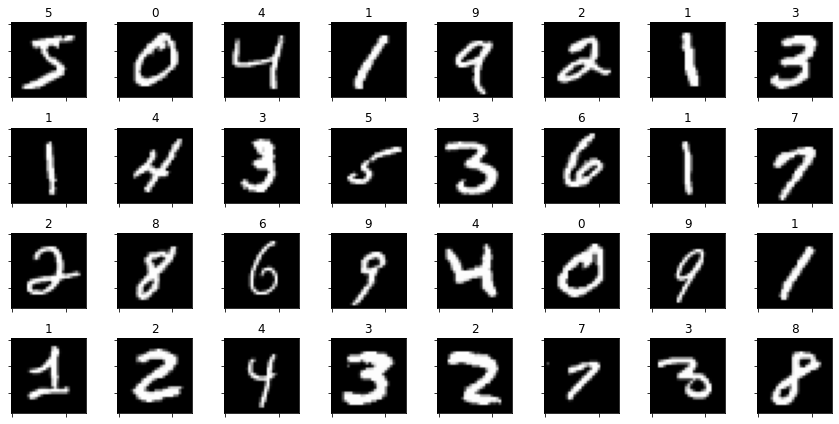

In [ ]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


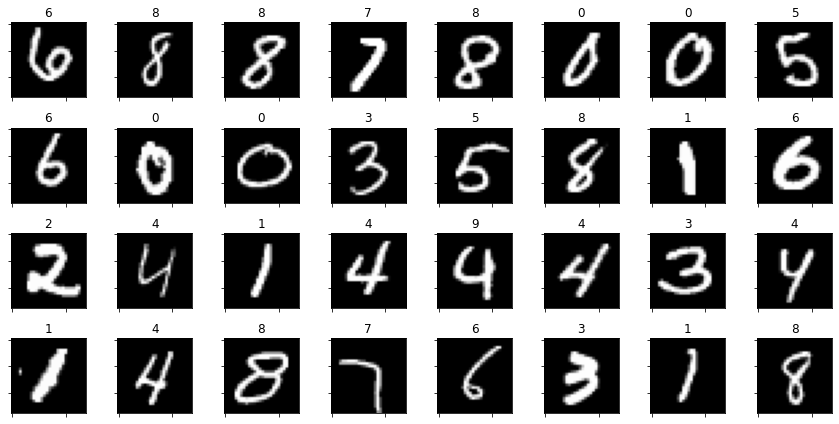

In [ ]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


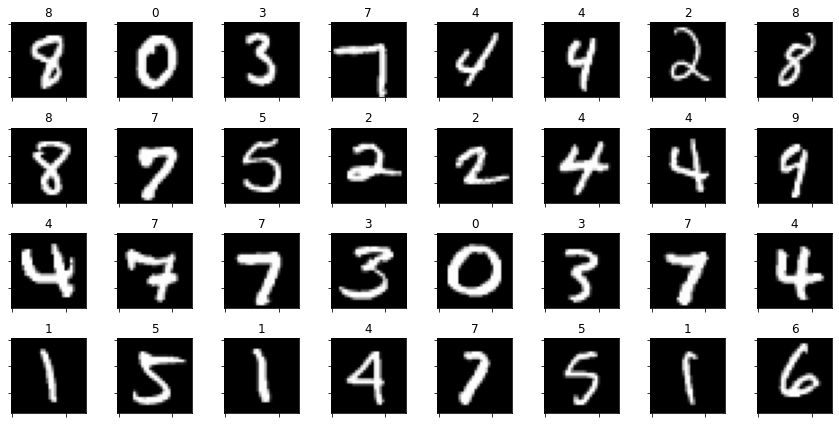

In [ ]:
# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

### Definición de diferentes arquitecturas

In [ ]:
seq_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,10)
)

In [ ]:
seq_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,392),
    nn.ReLU(),
    nn.Linear(392,196),
    nn.ReLU(),
    nn.Linear(196,10)
)

In [ ]:
seq_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,392),
    nn.ReLU(),
    nn.Linear(392,196),
    nn.ReLU(),
    nn.Linear(196,98),
    nn.ReLU(),
    nn.Linear(98,10)
)

In [ ]:
models = [seq_1, seq_2, seq_3]

### Ciclo de entrenamiento

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

### Función para realizar entrenamiento y evaluación de un modelo

In [ ]:
def train_evaluate_model(model, trn_dl, tst_dl, lr=1e-3, epochs=20):
  print(summary(model))
  
  print('---------------------------------------')
  print('Learning rate = {}\tEpochs = {}'.format(lr, epochs))
  print('---------------------------------------')
  # Entrenamiento del modelo#
  loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=lr, epochs=epochs)

  print('---------------------------------------')
  print('Evaluación')
  print('---------------------------------------')
  # Evaluación
  trn_loss, trn_acc = eval_epoch(trn_dl, model)
  tst_loss, tst_acc = eval_epoch(tst_dl, model)
  print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')
  print('\n')
  


### Definición de hiperparámetros

In [ ]:
learning_rate = [1e-2, 1e-3]
epochs = [10,20]

In [ ]:
for e in epochs:
  for lr in learning_rate:
    for model in models:
      train_evaluate_model(model, trn_dl, tst_dl, lr=lr, epochs=e)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            100,480
├─ReLU: 1-3                              --
├─Linear: 1-4                            1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
---------------------------------------
Learning rate = 0.01	Epochs = 10
---------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 42.47, 40.57] acc=[88.70,89.30]
E01 loss=[ 33.78, 32.35] acc=[90.52,90.90]
E02 loss=[ 30.20, 29.08] acc=[91.47,91.73]
E03 loss=[ 27.54, 26.70] acc=[92.17,92.51]
E04 loss=[ 25.30, 24.69] acc=[92.92,92.99]
E05 loss=[ 23.53, 23.13] acc=[93.45,93.42]
E06 loss=[ 22.15, 21.89] acc=[93.90,93.82]
E07 loss=[ 20.76, 20.64] acc=[94.19,94.03]
E08 loss=[ 19.41, 19.42] acc=[94.57,94.45]
E09 loss=[ 18.45, 18.57] acc=[94.81,94.57]
---------------------------------------
Evaluación
---------------------------------------
loss=[ 18.45, 18.57] acc=[94.81,94.57]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            307,720
├─ReLU: 1-3                              --
├─Linear: 1-4                            77,028
├─ReLU: 1-5                              --
├─Linear: 1-6                            1,970
Total params: 386,718
Trainable params: 386,718
Non-trainable params:

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 42.13, 40.60] acc=[88.57,89.00]
E01 loss=[ 31.67, 30.65] acc=[91.07,91.47]
E02 loss=[ 26.94, 26.25] acc=[92.38,92.55]
E03 loss=[ 24.10, 23.85] acc=[93.13,93.11]
E04 loss=[ 21.38, 21.20] acc=[93.91,93.71]
E05 loss=[ 18.58, 18.62] acc=[94.74,94.38]
E06 loss=[ 16.75, 17.12] acc=[95.21,94.96]
E07 loss=[ 15.18, 15.58] acc=[95.65,95.50]
E08 loss=[ 14.20, 14.80] acc=[95.89,95.56]
E09 loss=[ 12.33, 13.13] acc=[96.54,96.17]
---------------------------------------
Evaluación
---------------------------------------
loss=[ 12.33, 13.13] acc=[96.54,96.17]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            307,720
├─ReLU: 1-3                              --
├─Linear: 1-4                            77,028
├─ReLU: 1-5                              --
├─Linear: 1-6                            19,306
├─ReLU: 1-7                              --
├─Linear: 1-8           

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 59.66, 58.16] acc=[82.20,82.47]
E01 loss=[ 36.35, 35.42] acc=[89.50,89.90]
E02 loss=[ 28.88, 28.13] acc=[91.63,91.53]
E03 loss=[ 23.26, 23.01] acc=[93.30,93.39]
E04 loss=[ 18.96, 18.98] acc=[94.60,94.47]
E05 loss=[ 15.78, 16.23] acc=[95.54,95.32]
E06 loss=[ 13.90, 14.54] acc=[96.04,95.74]
E07 loss=[ 12.03, 13.24] acc=[96.53,95.99]
E08 loss=[ 10.53, 11.88] acc=[96.92,96.40]
E09 loss=[  9.69, 11.75] acc=[97.17,96.47]
---------------------------------------
Evaluación
---------------------------------------
loss=[  9.69, 11.75] acc=[97.17,96.47]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            100,480
├─ReLU: 1-3                              --
├─Linear: 1-4                            1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
---------------------------------------
Learning rate = 0.001	Epochs = 10
---------------

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 18.18, 18.29] acc=[94.90,94.67]
E01 loss=[ 18.07, 18.24] acc=[94.95,94.64]
E02 loss=[ 17.97, 18.18] acc=[95.00,94.63]
E03 loss=[ 17.88, 18.05] acc=[94.99,94.68]
E04 loss=[ 17.78, 18.04] acc=[95.01,94.72]
E05 loss=[ 17.68, 17.86] acc=[95.05,94.73]
E06 loss=[ 17.58, 17.81] acc=[95.08,94.73]
E07 loss=[ 17.50, 17.74] acc=[95.08,94.79]
E08 loss=[ 17.39, 17.63] acc=[95.15,94.75]
E09 loss=[ 17.30, 17.55] acc=[95.16,94.87]
---------------------------------------
Evaluación
---------------------------------------
loss=[ 17.30, 17.55] acc=[95.16,94.87]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            307,720
├─ReLU: 1-3                              --
├─Linear: 1-4                            77,028
├─ReLU: 1-5                              --
├─Linear: 1-6                            1,970
Total params: 386,718
Trainable params: 386,718
Non-trainable params:

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[ 12.14, 13.00] acc=[96.59,96.15]
E01 loss=[ 12.02, 12.92] acc=[96.64,96.19]
E02 loss=[ 11.91, 12.89] acc=[96.67,96.20]
E03 loss=[ 11.81, 12.77] acc=[96.72,96.24]
E04 loss=[ 11.69, 12.72] acc=[96.71,96.19]
E05 loss=[ 11.58, 12.59] acc=[96.78,96.29]
E06 loss=[ 11.48, 12.53] acc=[96.79,96.34]
E07 loss=[ 11.39, 12.41] acc=[96.83,96.35]
E08 loss=[ 11.29, 12.36] acc=[96.85,96.37]
E09 loss=[ 11.18, 12.30] acc=[96.89,96.31]
---------------------------------------
Evaluación
---------------------------------------
loss=[ 11.18, 12.32] acc=[96.89,96.30]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            307,720
├─ReLU: 1-3                              --
├─Linear: 1-4                            77,028
├─ReLU: 1-5                              --
├─Linear: 1-6                            19,306
├─ReLU: 1-7                              --
├─Linear: 1-8           

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[  8.58, 10.50] acc=[97.58,96.75]
E01 loss=[  8.45, 10.38] acc=[97.61,96.84]
E02 loss=[  8.36, 10.34] acc=[97.67,96.90]
E03 loss=[  8.22, 10.30] acc=[97.67,96.86]
E04 loss=[  8.16, 10.24] acc=[97.67,96.86]
E05 loss=[  8.03, 10.14] acc=[97.70,96.91]
E06 loss=[  7.95, 10.10] acc=[97.75,96.95]
E07 loss=[  7.83,  9.99] acc=[97.76,96.90]
E08 loss=[  7.70,  9.96] acc=[97.82,97.00]
E09 loss=[  7.64, 10.04] acc=[97.87,96.95]
---------------------------------------
Evaluación
---------------------------------------
loss=[  7.64, 10.00] acc=[97.87,96.96]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            100,480
├─ReLU: 1-3                              --
├─Linear: 1-4                            1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
---------------------------------------
Learning rate = 0.01	Epochs = 20
----------------

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 16.64, 17.19] acc=[95.32,95.03]
E01 loss=[ 15.88, 16.31] acc=[95.53,95.18]
E02 loss=[ 15.01, 15.58] acc=[95.82,95.51]
E03 loss=[ 14.37, 14.91] acc=[95.95,95.58]
E04 loss=[ 13.64, 14.30] acc=[96.16,95.87]
E05 loss=[ 13.07, 13.86] acc=[96.34,95.90]
E06 loss=[ 12.53, 13.43] acc=[96.52,96.08]
E07 loss=[ 12.06, 13.07] acc=[96.66,96.17]
E08 loss=[ 11.57, 12.54] acc=[96.78,96.41]
E09 loss=[ 11.27, 12.38] acc=[96.87,96.45]
E10 loss=[ 10.81, 12.09] acc=[97.02,96.55]
E11 loss=[ 10.41, 11.69] acc=[97.16,96.72]
E12 loss=[ 10.16, 11.41] acc=[97.18,96.70]
E13 loss=[  9.74, 11.16] acc=[97.31,96.82]
E14 loss=[  9.47, 11.01] acc=[97.44,96.87]
E15 loss=[  9.13, 10.72] acc=[97.49,96.93]
E16 loss=[  8.92, 10.48] acc=[97.54,96.97]
E17 loss=[  8.61, 10.30] acc=[97.66,96.98]
E18 loss=[  8.36, 10.10] acc=[97.73,97.15]
E19 loss=[  8.15,  9.94] acc=[97.79,97.12]
---------------------------------------
Evaluación
---------------------------------------
loss=[  8.15,  9.95] acc=[97.79,97.12]


Layer (t

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[ 10.69, 11.96] acc=[96.99,96.45]
E01 loss=[  9.73, 11.08] acc=[97.27,96.62]
E02 loss=[  9.03, 10.70] acc=[97.47,96.80]
E03 loss=[  8.42, 10.14] acc=[97.63,96.93]
E04 loss=[  8.01, 10.01] acc=[97.73,96.89]
E05 loss=[  7.15,  9.24] acc=[98.03,97.19]
E06 loss=[  6.87,  9.18] acc=[98.10,97.18]
E07 loss=[  6.33,  8.61] acc=[98.23,97.27]
E08 loss=[  5.99,  8.57] acc=[98.38,97.42]
E09 loss=[  5.59,  8.28] acc=[98.52,97.49]
E10 loss=[  5.40,  8.14] acc=[98.56,97.53]
E11 loss=[  5.01,  7.73] acc=[98.66,97.58]
E12 loss=[  4.78,  7.79] acc=[98.74,97.68]
E13 loss=[  4.34,  7.48] acc=[98.92,97.64]
E14 loss=[  4.14,  7.42] acc=[98.94,97.66]
E15 loss=[  3.95,  7.25] acc=[99.02,97.78]
E16 loss=[  3.96,  7.44] acc=[98.96,97.84]
E17 loss=[  3.45,  7.03] acc=[99.15,97.86]
E18 loss=[  3.31,  7.15] acc=[99.21,97.82]
E19 loss=[  3.24,  7.01] acc=[99.23,97.82]
---------------------------------------
Evaluación
---------------------------------------
loss=[  3.24,  7.01] acc=[99.23,97.82]


Layer (t

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[  7.51,  9.77] acc=[97.82,96.97]
E01 loss=[  6.86,  9.83] acc=[98.09,96.96]
E02 loss=[  5.80,  8.91] acc=[98.36,97.20]
E03 loss=[  5.24,  8.67] acc=[98.55,97.29]
E04 loss=[  4.81,  8.39] acc=[98.72,97.47]
E05 loss=[  4.45,  8.17] acc=[98.76,97.64]
E06 loss=[  3.72,  7.77] acc=[99.08,97.63]
E07 loss=[  3.64,  7.83] acc=[99.03,97.74]
E08 loss=[  3.09,  7.46] acc=[99.23,97.80]
E09 loss=[  2.91,  7.46] acc=[99.25,97.78]
E10 loss=[  2.49,  7.30] acc=[99.46,97.77]
E11 loss=[  2.34,  7.45] acc=[99.47,97.75]
E12 loss=[  2.12,  7.44] acc=[99.53,97.81]
E13 loss=[  1.86,  7.45] acc=[99.64,97.80]
E14 loss=[  1.71,  7.51] acc=[99.66,97.73]
E15 loss=[  1.58,  7.35] acc=[99.71,97.84]
E16 loss=[  1.36,  7.49] acc=[99.79,97.81]
E17 loss=[  1.48,  7.93] acc=[99.72,97.74]
E18 loss=[  1.09,  7.22] acc=[99.86,97.93]
E19 loss=[  1.10,  7.66] acc=[99.83,97.86]
---------------------------------------
Evaluación
---------------------------------------
loss=[  1.10,  7.66] acc=[99.83,97.86]


Layer (t

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[  8.04,  9.87] acc=[97.84,97.08]
E01 loss=[  8.01,  9.84] acc=[97.84,97.10]
E02 loss=[  7.98,  9.84] acc=[97.86,97.13]
E03 loss=[  7.96,  9.85] acc=[97.86,97.11]
E04 loss=[  7.94,  9.81] acc=[97.88,97.15]
E05 loss=[  7.92,  9.80] acc=[97.87,97.13]
E06 loss=[  7.89,  9.82] acc=[97.88,97.12]
E07 loss=[  7.87,  9.75] acc=[97.90,97.15]
E08 loss=[  7.85,  9.76] acc=[97.90,97.18]
E09 loss=[  7.83,  9.74] acc=[97.91,97.19]
E10 loss=[  7.81,  9.73] acc=[97.91,97.20]
E11 loss=[  7.78,  9.71] acc=[97.91,97.20]
E12 loss=[  7.76,  9.70] acc=[97.92,97.17]
E13 loss=[  7.74,  9.66] acc=[97.92,97.15]
E14 loss=[  7.72,  9.64] acc=[97.94,97.20]
E15 loss=[  7.70,  9.64] acc=[97.95,97.21]
E16 loss=[  7.68,  9.64] acc=[97.94,97.19]
E17 loss=[  7.66,  9.62] acc=[97.96,97.22]
E18 loss=[  7.64,  9.60] acc=[97.98,97.24]
E19 loss=[  7.62,  9.58] acc=[97.96,97.25]
---------------------------------------
Evaluación
---------------------------------------
loss=[  7.62,  9.59] acc=[97.96,97.25]


Layer (t

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[  2.95,  6.73] acc=[99.33,97.95]
E01 loss=[  2.91,  6.66] acc=[99.37,97.99]
E02 loss=[  2.89,  6.69] acc=[99.36,97.96]
E03 loss=[  2.87,  6.66] acc=[99.36,97.98]
E04 loss=[  2.85,  6.67] acc=[99.37,97.94]
E05 loss=[  2.83,  6.64] acc=[99.39,97.95]
E06 loss=[  2.81,  6.64] acc=[99.37,97.96]
E07 loss=[  2.80,  6.64] acc=[99.38,97.93]
E08 loss=[  2.78,  6.63] acc=[99.39,97.94]
E09 loss=[  2.77,  6.69] acc=[99.39,97.92]
E10 loss=[  2.75,  6.61] acc=[99.39,97.97]
E11 loss=[  2.73,  6.60] acc=[99.41,97.97]
E12 loss=[  2.72,  6.61] acc=[99.39,97.96]
E13 loss=[  2.70,  6.61] acc=[99.41,97.95]
E14 loss=[  2.69,  6.61] acc=[99.41,97.93]
E15 loss=[  2.67,  6.60] acc=[99.42,97.96]
E16 loss=[  2.66,  6.60] acc=[99.43,97.95]
E17 loss=[  2.64,  6.60] acc=[99.42,97.95]
E18 loss=[  2.63,  6.56] acc=[99.43,97.99]
E19 loss=[  2.62,  6.57] acc=[99.45,97.99]
---------------------------------------
Evaluación
---------------------------------------
loss=[  2.62,  6.57] acc=[99.45,97.99]


Layer (t

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[  0.87,  7.30] acc=[99.91,97.99]
E01 loss=[  0.85,  7.28] acc=[99.90,97.97]
E02 loss=[  0.84,  7.36] acc=[99.91,97.97]
E03 loss=[  0.83,  7.23] acc=[99.91,97.99]
E04 loss=[  0.82,  7.25] acc=[99.91,98.00]
E05 loss=[  0.81,  7.27] acc=[99.91,97.96]
E06 loss=[  0.80,  7.27] acc=[99.92,98.02]
E07 loss=[  0.79,  7.26] acc=[99.92,98.00]
E08 loss=[  0.78,  7.31] acc=[99.92,97.98]
E09 loss=[  0.77,  7.31] acc=[99.93,97.94]
E10 loss=[  0.77,  7.36] acc=[99.93,97.96]
E11 loss=[  0.76,  7.30] acc=[99.92,97.98]
E12 loss=[  0.75,  7.32] acc=[99.93,97.98]
E13 loss=[  0.74,  7.31] acc=[99.93,97.98]
E14 loss=[  0.74,  7.40] acc=[99.93,97.92]
E15 loss=[  0.73,  7.37] acc=[99.93,97.93]
E16 loss=[  0.72,  7.35] acc=[99.94,97.97]
E17 loss=[  0.71,  7.34] acc=[99.94,97.96]
E18 loss=[  0.71,  7.35] acc=[99.93,97.98]
E19 loss=[  0.70,  7.36] acc=[99.94,97.97]
---------------------------------------
Evaluación
---------------------------------------
loss=[  0.70,  7.37] acc=[99.94,97.97]




### Resultados

Se probaron 3 diferentes arquitecturas, en las cuales se utiliza la función $ReLU(x)$ como función de activación. Las diferencias entre arquitecturas radican en el número de capas ocultas y en el número de neuronas por capa oculta.La función de pérdida es la entropía cruzada.
En relación a los hiperparámetros de entrenamiento se probaron tasas de aprendizaje de $0.01$ y $0.001$. Para el caso de las épocas se probaron $10$ y $20$ épocas. A continuación se muestra una tabla con los resultados obtenidos, los modelos se identifican como seq_1, seq_2 y seq_3, conforme fueron definidos en la sección **Definición de diferentes arquitecturas**. Para las métricas de exactitud y pérdida se utilizan los valores obtenidos en el conjunto de prueba.

|Modelo|Epocas|Tasa de aprendizaje|Exactitud|Pérdida|
|---|:---:|:---:|:---:|:---:|
|seq_1|10|0.01|94.57|18.57|
|||0.001|94.87|17.55|
||20|0.01|97.12|9.95|
|||0.001|97.25|9.59|
|seq_2|10|0.01|96.17|13.13|
|||0.001|96.30|12.32|
||20|0.01|97.82|7.01|
|||0.001|97.99|6.57|
|seq_3|10|0.01|96.47|11.75|
|||0.001|96.96|10.0|
||20|0.01|97.86|7.66|
|||0.001|97.97|7.37|

Para los tres modelos se observa que se tienen sus mejores resultados cuando se tiene una tasa de aprendizaje $0.001$ y se entrenan por $20$ épocas. Ya que obtienen exactitudes de 97.25, 97.99 y 97.97 respectivamente.

Sin embargo, se observa que el modelo seq_2 es el que obtiene el mayor rendimiento de las 3 arquitecturas propuestas. Este modelo consta de 1 capa de entrada, 2 capas ocultas y una capa de salida. Con respecto a la exactitud, presenta una mejora de 0.74 respecto al modelo seq_1 y de 0.02 respecto a la arquitectura seq_3. En relación a la función de pérdida, se observan diferencias de 3.02 y 0.8.

Con este experimento se observa que aumentar la complejidad del modelo no siempre significa la obtención de mejores resultados, ya que si bien hay una mejora cuando se emplean dos capas ocultas, cuando se agrega una tercera capa oculta, el rendimiento del modelo comienza a decrementar.

